# Load libraries

In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from sklearn.model_selection import LeaveOneGroupOut

# Load configuration

In [5]:
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
           'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
#   'timestamp_hour'
features += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Load dataset

In [6]:
df = pd.read_excel('./data/4-combined_data.xlsx',
                  index_col="timestamp",
                  usecols=columns,
                  sheet_name="combined",
                  engine='openpyxl')

# Fill missing data with 0
df.fillna(0, inplace=True)

In [7]:
print(len(df))
display(df.head())

16608


,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,timestamp_hour_sin,timestamp_hour_cos,timestamp_dayofweek,wearing_off,participant
timestamp,,,,,,,,,,,,,,,,
2021-11-25 00:00:00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-7.627160e-12,1.000000,3,0,1
2021-11-25 00:15:00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.540313e-02,0.997859,3,0,1
2021-11-25 00:30:00,21.95,0.0,-0.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.305262e-01,0.991445,3,0,1
2021-11-25 00:45:00,60.25,0.0,12.4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.950903e-01,0.980785,3,0,1
2021-11-25 01:00:00,10.60,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.588190e-01,0.965926,3,0,1


In [ ]:
# # Remove days without wearing-off record (UNDERSAMPLING)
# #   * not sure whether there is no actual wearing-off periods that day
# #   * or if there were actual wearing-off periods but not recorded
# df.pivot_table(values='wearing_off', index=["participant"], aggfunc='count')

# df_day = df.resample('D').sum()
# days_without_wearing_off = list(df_day.query('wearing_off != 0').index)
# days_without_wearing_off = [day.date().strftime('%Y-%m-%d') for day in days_without_wearing_off]

# df['date'] = pd.to_datetime(df.index.date)
# df = df[df['date'].dt.date.astype(str).isin(days_without_wearing_off)][features + ['participant']]
# # df[df['date'].dt.date.astype(str).isin(days_without_wearing_off)].pivot_table(values='wearing_off', index=["participant"], aggfunc='count')

# print(len(df))
# display(df.head())

# Split dataset

In [8]:
PARTICIPANT_AS_TEST = 9

column_indices = {name: i for i, name in enumerate(df.columns)}
# Select all except specified participant (used for training)
general_df = df.query(f'participant != {PARTICIPANT_AS_TEST}')[features].copy()
train_df = general_df[0:int( len(general_df) * 0.6 )]
val_df = general_df[int( len(general_df) * 0.6 ):]

test_participant_df = df.query(f'participant == {PARTICIPANT_AS_TEST}')[features].copy()
fine_tuning_df = test_participant_df[0:int( len(test_participant_df) * 0.5 )]
test_df = test_participant_df[int( len(test_participant_df) * 0.5 ):]

# Normalize dataset

In [9]:
normalize_features = ['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 
                      'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage',
                      'sleep_efficiency', 'timestamp_hour_sin', 'timestamp_hour_cos']
def normalize_data(df, mean, std, normalize_features=normalize_features):
    df_to_normalize = df.copy()
    df_to_normalize.loc[:, normalize_features] = ((
        df_to_normalize.loc[:, normalize_features] - mean
    ) / std)
    
    return df_to_normalize

In [10]:
general_mean = general_df.loc[:, normalize_features].mean()
general_std = general_df.loc[:, normalize_features].std()

train_df = normalize_data(train_df, general_mean, general_std)
val_df = normalize_data(val_df, general_mean, general_std)
fine_tuning_df = normalize_data(fine_tuning_df, general_mean, general_std)
test_df = normalize_data(test_df, general_mean, general_std)

# WindowGenerator

In [11]:
BATCH_SIZE = 32
SHIFT = 4
RECORD_SIZE_PER_DAY = 96


class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, fine_tuning_df, test_df, 
               label_columns=None, batch_size=1):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.fine_tuning_df = fine_tuning_df
    self.test_df = test_df
    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(self.train_df.columns)}
    
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='wearing_off', max_subplots=3):
    inputs, labels = self.example
    
    fig = plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      ax = plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      
      # NEW
      plt.ylim(-0.1,1.1) 
      ax.set_yticks(
          [0.0, 0.5, 1.0]
      )
      ax.set_xticks([])
      if n == 2:
          ax.set_xticks(
              np.append(self.input_indices[::SHIFT], self.input_indices[-1] + 1),
              list(range(0, len( self.input_indices[::SHIFT] ) + 1 )),
              minor=True
          )
      # NEW

      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index
      if label_col_index is None:
        continue

      # plt.scatter(self.label_indices, labels[n, :, label_col_index],
      #             edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(self.label_indices[::SHIFT], labels[n, :, label_col_index][::SHIFT],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices[::SHIFT], predictions[n, :, label_col_index][::SHIFT],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
        # plt.scatter(self.label_indices, predictions[n, :, label_col_index],
        #             marker='X', edgecolors='k', label='Predictions',
        #             c='#ff7f0e', s=64)

      if n == 2:
          # Put a legend below current axis
          plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.025),
                      bbox_transform=fig.transFigure,
                    fancybox=True, shadow=True, ncol=3)
          # plt.legend()
      # if n == 0:
      #   plt.legend()


    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      seed=4,
      batch_size=BATCH_SIZE,).shuffle(buffer_size=10000)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def fine_tuning(self):
    return self.make_dataset(self.fine_tuning_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

## Single Step Window

In [12]:
single_step_window = WindowGenerator(
    train_df=train_df, val_df=val_df,
    fine_tuning_df=fine_tuning_df, test_df=test_df,
    input_width=1, label_width=1, shift=SHIFT,
    label_columns=[TARGET_COLUMN], batch_size=BATCH_SIZE)
# print(single_step_window)
# for example_inputs, example_labels in single_step_window.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')
# single_step_window.plot(plot_col=TARGET_COLUMN)

## Wide Window

In [13]:
wide_window = WindowGenerator(
    train_df=train_df, val_df=val_df,
    fine_tuning_df=fine_tuning_df, test_df=test_df,
    input_width=24, label_width=24, shift=SHIFT,
    label_columns=[TARGET_COLUMN], batch_size=BATCH_SIZE)
# print(wide_window)
# for example_inputs, example_labels in wide_window.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')
# wide_window.plot(plot_col=TARGET_COLUMN)

## Convolutional Window

In [14]:
CONV_WIDTH = RECORD_SIZE_PER_DAY # 24 hours or 96 records
conv_window = WindowGenerator(
    train_df=train_df, val_df=val_df,
    fine_tuning_df=fine_tuning_df, test_df=test_df,
    input_width=CONV_WIDTH, label_width=1, shift=SHIFT,
    label_columns=[TARGET_COLUMN], batch_size=BATCH_SIZE)
# print(conv_window)
# for example_inputs, example_labels in conv_window.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')
# conv_window.plot(plot_col=TARGET_COLUMN)

## Wide Convolutional Window

In [15]:
LABEL_WIDTH = CONV_WIDTH # 4 * 6 # 4 records * 6 hours
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    train_df=train_df, val_df=val_df,
    fine_tuning_df=fine_tuning_df, test_df=test_df,
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
    label_columns=[TARGET_COLUMN], batch_size=BATCH_SIZE)
# print(wide_conv_window)
# for example_inputs, example_labels in wide_conv_window.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')
# wide_conv_window.plot(plot_col=TARGET_COLUMN)

# Model Training

In [40]:
MAX_EPOCHS = 20
LEARNING_RATE = 1e-3
THRESHOLDS = [
    (i + 1) * 1.0 / (200 - 1)
    for i in range(200 - 2)
]
METRICS = [
  tf.keras.metrics.TruePositives(name='tp', thresholds=THRESHOLDS),
  tf.keras.metrics.FalsePositives(name='fp', thresholds=THRESHOLDS),
  tf.keras.metrics.TrueNegatives(name='tn', thresholds=THRESHOLDS),
  tf.keras.metrics.FalseNegatives(name='fn', thresholds=THRESHOLDS), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLDS),
  tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLDS),
  tf.keras.metrics.AUC(name='auc', thresholds=THRESHOLDS),
  tf.keras.metrics.AUC(name='prc', curve='PR', thresholds=THRESHOLDS, summation_method='majoring')] # precision-recall curve]


def brier_score_loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred))

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  # model.compile(loss=tf.keras.losses.MeanSquaredError(),
  #               optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
  #               metrics=[tf.keras.metrics.MeanAbsoluteError()])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)
  # model.compile(loss=brier_score_loss,
  #               optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
  #               metrics=METRICS)

  # history = model.fit(window.train, epochs=MAX_EPOCHS,
  #                     validation_data=window.val,
  #                     callbacks=[early_stopping])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

def fine_tune(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)
  
  # model.compile(loss=brier_score_loss,
  #               optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
  #               metrics=METRICS)

  history = model.fit(window.fine_tuning, epochs=MAX_EPOCHS,
                    validation_data=window.val,
                    callbacks=[early_stopping])
  
  return history

In [18]:
val_performance = {}
before_fine_tuning_performance = {}
performance = {}

## Baseline

In [19]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [20]:
K.clear_session()
baseline = Baseline(label_index=column_indices[TARGET_COLUMN])
history = compile_and_fit(baseline, single_step_window)

2023-02-12 04:06:05.533113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
292/292 [==============================] - 4s 6ms/step - loss: 2.1344 - tp: 199.0000 - fp: 649.0000 - tn: 7830.0000 - fn: 649.0000 - accuracy: 0.8608 - precision: 0.2347 - recall: 0.2347 - auc: 0.5791 - prc: 0.1427 - val_loss: 1.8946 - val_tp: 24.0000 - val_fp: 384.0000 - val_tn: 5425.0000 - val_fn: 384.0000 - val_accuracy: 0.8765 - val_precision: 0.0588 - val_recall: 0.0588 - val_auc: 0.4964 - val_prc: 0.0644
Epoch 2/20
292/292 [==============================] - 1s 4ms/step - loss: 2.1344 - tp: 199.0000 - fp: 649.0000 - tn: 7830.0000 - fn: 649.0000 - accuracy: 0.8608 - precision: 0.2347 - recall: 0.2347 - auc: 0.5791 - prc: 0.1427 - val_loss: 1.8946 - val_tp: 24.0000 - val_fp: 384.0000 - val_tn: 5425.0000 - val_fn: 384.0000 - val_accuracy: 0.8765 - val_precision: 0.0588 - val_recall: 0.0588 - val_auc: 0.4964 - val_prc: 0.0644
Epoch 3/20
292/292 [==============================] - 2s 4ms/step - loss: 2.1344 - tp: 199.0000 - fp: 649.0000 - tn: 7830.0000 - fn: 649.0000 - accura

In [21]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
before_fine_tuning_performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
for name, value in zip(baseline.metrics_names, before_fine_tuning_performance['Baseline']):
  print(name, ': ', value)

195/195 [==============================] - 1s 2ms/step - loss: 1.8946 - tp: 24.0000 - fp: 384.0000 - tn: 5425.0000 - fn: 384.0000 - accuracy: 0.8765 - precision: 0.0588 - recall: 0.0588 - auc: 0.4964 - prc: 0.0644
loss :  1.0827949047088623
tp :  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5.]
fp :  [19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 1

In [22]:
history = fine_tune(baseline, single_step_window)

Epoch 1/20
17/17 [==============================] - 3s 81ms/step - loss: 1.4049 - tp: 31.0000 - fp: 43.0000 - tn: 932.0000 - fn: 42.0000 - accuracy: 0.9189 - precision: 0.4189 - recall: 0.4247 - auc: 0.6903 - prc: 0.2462 - val_loss: 1.8946 - val_tp: 24.0000 - val_fp: 384.0000 - val_tn: 5425.0000 - val_fn: 384.0000 - val_accuracy: 0.8765 - val_precision: 0.0588 - val_recall: 0.0588 - val_auc: 0.4964 - val_prc: 0.0644
Epoch 2/20
17/17 [==============================] - 1s 38ms/step - loss: 1.4049 - tp: 26.0000 - fp: 24.0000 - tn: 450.0000 - fn: 24.0000 - accuracy: 0.9084 - precision: 0.5200 - recall: 0.5200 - auc: 0.7347 - prc: 0.3505 - val_loss: 1.8946 - val_tp: 24.0000 - val_fp: 384.0000 - val_tn: 5425.0000 - val_fn: 384.0000 - val_accuracy: 0.8765 - val_precision: 0.0588 - val_recall: 0.0588 - val_auc: 0.4964 - val_prc: 0.0644
Epoch 3/20
17/17 [==============================] - 1s 38ms/step - loss: 1.4049 - tp: 26.0000 - fp: 24.0000 - tn: 450.0000 - fn: 24.0000 - accuracy: 0.9084 - pr

In [23]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
for name, value in zip(baseline.metrics_names, performance['Baseline']):
  print(name, ': ', value)

loss :  1.0827951431274414
tp :  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5.]
fp :  [19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 

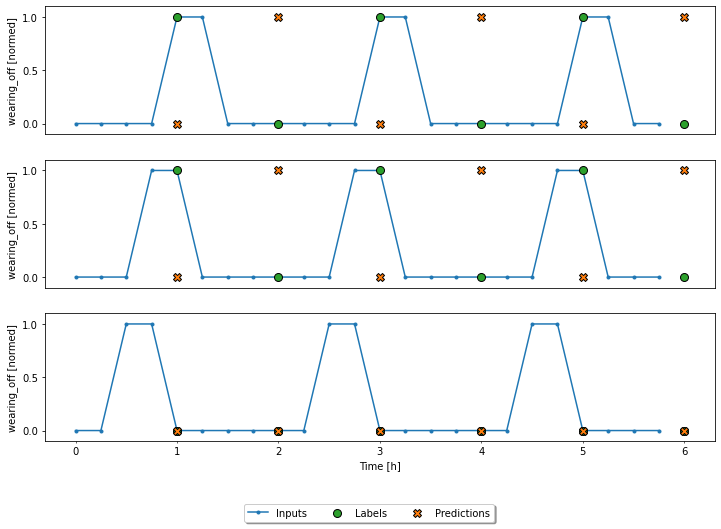

In [24]:
wide_window.plot(model=baseline, plot_col="wearing_off")

## Linear

In [41]:
K.clear_session()
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])
history = compile_and_fit(linear, single_step_window)

Epoch 1/20
292/292 [==============================] - 4s 6ms/step - loss: 1.4518 - tp: 573.5455 - fp: 5899.9194 - tn: 2579.0808 - fn: 274.4546 - accuracy: 0.2485 - precision: 0.0852 - recall: 0.6764 - auc: 0.4664 - prc: 0.0824 - val_loss: 0.8668 - val_tp: 199.1818 - val_fp: 3144.3940 - val_tn: 2664.6060 - val_fn: 208.8182 - val_accuracy: 0.4147 - val_precision: 0.0513 - val_recall: 0.4882 - val_auc: 0.4165 - val_prc: 0.0555
Epoch 2/20
292/292 [==============================] - 2s 4ms/step - loss: 0.8773 - tp: 433.2020 - fp: 4538.5049 - tn: 3940.4949 - fn: 414.7980 - accuracy: 0.4468 - precision: 0.0831 - recall: 0.5109 - auc: 0.4599 - prc: 0.0815 - val_loss: 0.5745 - val_tp: 149.7172 - val_fp: 2318.6616 - val_tn: 3490.3384 - val_fn: 258.2828 - val_accuracy: 0.7423 - val_precision: 0.0513 - val_recall: 0.3670 - val_auc: 0.4211 - val_prc: 0.0561
Epoch 3/20
292/292 [==============================] - 2s 4ms/step - loss: 0.5691 - tp: 309.9748 - fp: 3212.8586 - tn: 5266.1416 - fn: 538.0253 -

In [46]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
before_fine_tuning_performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
for name, value in zip(linear.metrics_names, before_fine_tuning_performance['Linear']):
  print(name, ': ', value)

195/195 [==============================] - 1s 2ms/step - loss: 0.2593 - tp: 51.5051 - fp: 659.4192 - tn: 5149.5806 - fn: 356.4950 - accuracy: 0.9344 - precision: 0.0203 - recall: 0.1262 - auc: 0.5824 - prc: 0.0770      
loss :  0.18336737155914307
tp :  [23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23.
 22. 22. 22. 22. 22. 22. 22. 21. 21. 21. 21. 18. 17. 17. 16. 15. 14. 12.
 12. 11. 11. 11. 10.  8.  8.  7.  7.  7.  7.  6.  6.  5.  5.  5.  5.  5.
  4.  4.  4.  4.  4.  4.  4.  3.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.

In [ ]:
history = fine_tune(linear, single_step_window)

In [ ]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
for name, value in zip(linear.metrics_names, performance['Linear']):
  print(name, ': ', value)

In [ ]:
wide_window.plot(model=linear, plot_col="wearing_off")

## Dense

In [ ]:
K.clear_session()
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation="sigmoid")

])
history = compile_and_fit(dense, single_step_window)

In [ ]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
before_fine_tuning_performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
for name, value in zip(dense.metrics_names, before_fine_tuning_performance['Dense']):
  print(name, ': ', value)

In [ ]:
history = fine_tune(dense, single_step_window)

In [ ]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
for name, value in zip(dense.metrics_names, performance['Dense']):
  print(name, ': ', value)

In [ ]:
wide_window.plot(model=dense, plot_col="wearing_off")

## Multi-step Dense

In [ ]:
K.clear_session()
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
history = compile_and_fit(multi_step_dense, conv_window)

In [ ]:
val_performance['Multi step Dense'] = multi_step_dense.evaluate(conv_window.val)
before_fine_tuning_performance['Multi step Dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
for name, value in zip(multi_step_dense.metrics_names, before_fine_tuning_performance['Multi step Dense']):
  print(name, ': ', value)

In [ ]:
history = fine_tune(multi_step_dense, conv_window)

In [ ]:
performance['Multi step Dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
for name, value in zip(multi_step_dense.metrics_names, performance['Multi step Dense']):
  print(name, ': ', value)

In [ ]:
conv_window.plot(model=multi_step_dense, plot_col="wearing_off")

## CNN

In [ ]:
K.clear_session()
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
history = compile_and_fit(conv_model, conv_window)

In [ ]:
val_performance['CNN'] = conv_model.evaluate(conv_window.val)
before_fine_tuning_performance['CNN'] = conv_model.evaluate(conv_window.test, verbose=0)
for name, value in zip(conv_model.metrics_names, before_fine_tuning_performance['CNN']):
  print(name, ': ', value)

In [ ]:
history = fine_tune(conv_model, conv_window)

In [ ]:
performance['CNN'] = conv_model.evaluate(conv_window.test, verbose=0)
for name, value in zip(conv_model.metrics_names, performance['CNN']):
  print(name, ': ', value)

In [ ]:
wide_conv_window.plot(model=conv_model, plot_col='wearing_off')

## LSTM

In [ ]:
K.clear_session()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

history = compile_and_fit(lstm_model, wide_window)


In [ ]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
before_fine_tuning_performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
for name, value in zip(lstm_model.metrics_names, before_fine_tuning_performance['LSTM']):
  print(name, ': ', value)

In [ ]:
history = fine_tune(lstm_model, wide_window)

In [ ]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
for name, value in zip(lstm_model.metrics_names, performance['LSTM']):
  print(name, ': ', value)

In [ ]:
wide_window.plot(model=lstm_model, plot_col='wearing_off')

## Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'prc'
metric_index = lstm_model.metrics_names.index(metric_name)
# val_mae = [v[metric_index] for v in val_performance.values()]
before_fine_tuning_mae = [v[metric_index] for v in before_fine_tuning_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'{metric_name} [wearing_off, normalized]')
# plt.bar(x - 0.17, before_fine_tuning_mae, width, label='Validation')
plt.bar(x - 0.17, before_fine_tuning_mae, width, label='Before Fine-Tuning Test')
plt.bar(x + 0.17, test_mae, width, label='After Fine-Tuning Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
# if os.path.exists(f'./results/final_performance.xlsx'):
#     with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
#         pd.DataFrame(
#             val_performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="validation", startrow=writer.sheets['validation'].max_row, header=None)

#         pd.DataFrame(
#             before_fine_tuning_performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="before fine-tuning", startrow=writer.sheets['before fine-tuning'].max_row, header=None)

#         pd.DataFrame(
#             performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="after fine-tuning", startrow=writer.sheets['after fine-tuning'].max_row, header=None)
# else:
#     with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='w') as writer:
#         pd.DataFrame(
#             val_performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="validation")

#         pd.DataFrame(
#             before_fine_tuning_performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="before fine-tuning")

#         pd.DataFrame(
#             performance, index=lstm_model.metrics_names
#         ).assign(
#             participant=PARTICIPANT_AS_TEST
#         ).to_excel(writer, sheet_name="after fine-tuning")

In [ ]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [ ]:
display_side_by_side([
  pd.DataFrame(val_performance, index=lstm_model.metrics_names),
  # pd.DataFrame(before_fine_tuning_performance, index=lstm_model.metrics_names),
  # pd.DataFrame(performance, index=lstm_model.metrics_names)
], [
  'validation',
  # 'before fine-tuning',
  # 'after fine-tuning'
])

## Residual Connections

In [ ]:
# wide_window = WindowGenerator(
#     train_df=train_df, val_df=val_df,
#     fine_tuning_df=fine_tuning_df, test_df=test_df,
#     input_width=24, label_width=24, shift=1,
#     batch_size=BATCH_SIZE)
# print(wide_window)
# for example_inputs, example_labels in wide_window.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')
# wide_window.plot(plot_col=TARGET_COLUMN)

In [ ]:
# def compile_and_fit(model, window, patience=2):
#   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#   model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
#   # model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#   #               optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#   #               metrics=METRICS)
#   # model.compile(loss=brier_score_loss,
#   #               optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#   #               metrics=METRICS)

#   # history = model.fit(window.train, epochs=MAX_EPOCHS,
#   #                     validation_data=window.val,
#   #                     callbacks=[early_stopping])
#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])

In [ ]:
# class ResidualWrapper(tf.keras.Model):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model

#   def call(self, inputs, *args, **kwargs):
#     delta = self.model(inputs, *args, **kwargs)

#     # The prediction for each time step is the input
#     # from the previous time step plus the delta
#     # calculated by the model.
#     return inputs + delta

In [ ]:
# K.clear_session()
# residual_lstm = ResidualWrapper(
#     tf.keras.Sequential([
#         tf.keras.layers.LSTM(32, return_sequences=True),
#         tf.keras.layers.Dense(
#             units=len(features),
#             # # The predicted deltas should start small.
#             # # Therefore, initialize the output layer with zeros.
#             kernel_initializer=tf.initializers.zeros())
#     ])
# )

# history = compile_and_fit(residual_lstm, wide_window)

In [ ]:
# val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
# performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
# for name, value in zip(residual_lstm.metrics_names, performance['Residual LSTM']):
#   print(name, ': ', value)

In [ ]:
# wide_window.plot(model=residual_lstm)

In [ ]:
# x = np.arange(len(performance))
# width = 0.3
# metric_name = 'mean_absolute_error'
# metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.ylabel('mean_absolute_error [T (degC), normalized]')
# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# _ = plt.legend()

# Plot loss

In [ ]:
# metrics = ['loss'] #, 'balanced_accuracy', 'auc', 'prc', 'precision', 'recall']
# plt.figure(figsize=(25, 10))
# for n, metric in enumerate(metrics):
#     name = metric.replace("_"," ").capitalize()
#     plt.subplot(3,3,n+1)
#     plt.plot(history.epoch, history.history[metric], label='Train')
#     plt.plot(history.epoch, history.history['val_'+metric], label='Validation')
#     plt.xlabel('Epoch')
#     plt.ylabel(name)
#     if metric == 'loss':
#       plt.ylim([0, plt.ylim()[1]])
#     # # elif metric == 'auc':
#     # #   plt.ylim([0.8,1])
#     # else:
#     #   plt.ylim([0,1])
#     plt.legend()
# plt.show()

# Predict using Model

In [ ]:
# def data_loader(new_df):
#     return np.array(new_df, dtype=np.float32)[np.newaxis, ...]
# linear.predict(data_loader(test_df.head(4))) # [0,:4]

In [ ]:
# inputs = None
# labels = None

# for input, label in single_step_window.val.as_numpy_iterator():
#   if inputs is None:
#     inputs = input
#     labels = label
#   else:
#     inputs = np.concatenate([inputs, inputs])
#     labels = np.concatenate([labels, labels])

# Export Model

In [ ]:
# saved_model = tf.saved_model.load(model_path)

In [ ]:
# saved_model(data_loader(test_df.iloc[0:36, :]), training=False)[:,:,14]

In [ ]:
# saved_model(data_loader(test_df.iloc[0:24, :]).tolist(), training=False)[:,:,14]

In [ ]:
# print(data_loader(test_df.iloc[0:36, :]).tolist())

In [ ]:
# data_loader(test_df.iloc[0:36, :]).shape